In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
import json

# Set stop words
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aubrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step One: Combine revenue and rotten tomatoes datasets

In [2]:
movies = pd.read_csv("rotten_tomatoes_movies.csv").drop(['movie_info', 'critics_consensus', 'directors', 'authors', 'actors', 'streaming_release_date', 
                                                         'runtime', 'production_company'], axis = 1)
reviews = pd.read_csv("rotten_tomatoes_critic_reviews.csv").drop(['critic_name', 'top_critic', 'publisher_name', 'review_date'], axis = 1)
revenue = pd.read_csv("movie_revenue.csv", low_memory = False).drop(['adult', 'homepage', 'imdb_id', 'id', 'poster_path', 'production_companies', 
                                                                     'production_countries', 'spoken_languages', 'status', 'tagline', 'video', 
                                                                     'vote_average', 'vote_count', 'original_title'], axis = 1)

In [3]:
tomatoes = pd.merge(movies, reviews, on='rotten_tomatoes_link')

In [4]:
tomatoes = tomatoes.rename({'movie_title': 'title', 'original_release_date': 'release_date'}, axis = 1)

In [5]:
tomatoes['release_date'] = tomatoes['release_date'] + " 00:00:00"
revenue = revenue.sort_values('revenue', ascending=False).drop_duplicates('title').sort_index()
revenue = revenue[revenue['revenue'] > 0]

In [6]:
data = pd.merge(tomatoes, revenue, on=['title'])
len(data['title'].unique())

5301

In [7]:
data.columns

Index(['rotten_tomatoes_link', 'title', 'content_rating', 'genres_x',
       'release_date_x', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'review_type', 'review_score', 'review_content',
       'belongs_to_collection', 'budget', 'genres_y', 'original_language',
       'overview', 'popularity', 'release_date_y', 'revenue', 'runtime'],
      dtype='object')

In [8]:
data = pd.get_dummies(data, columns = ['content_rating'])
data.columns

Index(['rotten_tomatoes_link', 'title', 'genres_x', 'release_date_x',
       'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       'audience_status', 'audience_rating', 'audience_count',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'review_type', 'review_score',
       'review_content', 'belongs_to_collection', 'budget', 'genres_y',
       'original_language', 'overview', 'popularity', 'release_date_y',
       'revenue', 'runtime', 'content_rating_G', 'content_rating_NC17',
       'content_rating_NR', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R'],
      dtype='object')

In [9]:
data.belongs_to_collection

0         {'id': 179919, 'name': 'Percy Jackson Collecti...
1         {'id': 179919, 'name': 'Percy Jackson Collecti...
2         {'id': 179919, 'name': 'Percy Jackson Collecti...
3         {'id': 179919, 'name': 'Percy Jackson Collecti...
4         {'id': 179919, 'name': 'Percy Jackson Collecti...
                                ...                        
620457    {'id': 374386, 'name': 'Anglo-Zulu War Collect...
620458    {'id': 374386, 'name': 'Anglo-Zulu War Collect...
620459    {'id': 374386, 'name': 'Anglo-Zulu War Collect...
620460    {'id': 374386, 'name': 'Anglo-Zulu War Collect...
620461    {'id': 374386, 'name': 'Anglo-Zulu War Collect...
Name: belongs_to_collection, Length: 620462, dtype: object

In [10]:
model_data = data[['revenue', 'release_date_x', 'title', 'tomatometer_rating', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 
                   'audience_rating', 'audience_count', 'budget', 'runtime', 'popularity', 'content_rating_G', 'content_rating_NC17', 'content_rating_NR', 
                   'content_rating_PG', 'content_rating_PG-13', 'content_rating_R']]

# Add review content as sentiemnt analysis
# Make belongs_to_collection into 0 and 1             

In [11]:
movies_revenue = model_data.title.unique()

In [12]:
movies_revenue.shape

(5301,)

Step Two: Implement LDA

In [13]:
reviews = pd.read_csv("rotten_tomatoes_critic_reviews.csv")
movies = pd.read_csv("rotten_tomatoes_movies.csv")

In [14]:
class LDA_reviews:
    def __init__(self, reviews,movies, N_topics=3, N_words = 10):
        # the narrative reviews
        self.reviews_full = reviews[reviews['review_content'].notna()]
        self.reviews = reviews['review_content']
        self.reviews = self.reviews[~self.reviews.isnull()]
        # initialize variables
        self.N_topics = N_topics
        self.N_words = N_words
        self.movies = movies
        
        # Get the word counts in the reviews
        self.countVectorizer = CountVectorizer(stop_words='english')
        self.termFrequency = self.countVectorizer.fit_transform(self.reviews)
        self.Words = self.countVectorizer.get_feature_names()
        
    def Topics(self):
        # Obtain the estimates for the LDA model

        self.lda = LatentDirichletAllocation(n_components=self.N_topics)
        self.lda.fit(self.termFrequency)
        
        # Obtain the list of the top N_words in the topics
        topics = list()
        for topic in self.lda.components_:
            topics.append([self.Words[i] for i in topic.argsort()[:-self.N_words - 1:-1]])
            
        # Create a list of column names, Words, for the dataframe output
        cols = list()
        for i in range(self.N_words):
            cols.append("Word "+(str(i)))
        
        # Create a dataframe with the topic no. and the words in each topic 
        # output this dataframe
        Topics_df = pd.DataFrame(topics, columns = cols)
        Topics_df.index.name = "Topics"
        return Topics_df  
        
    
    def Predict_Topics(self, movie_title):
        #find title in movie dataset, and then find corresponding rotten_tomatoes_link
        #try:
        idx_rotten = self.movies[self.movies['movie_title']==movie_title].index.values[0]
        link = self.movies['rotten_tomatoes_link'][idx_rotten]
        rotten_review = self.reviews_full['review_content'].where(self.reviews_full['rotten_tomatoes_link']==link)
        rotten_review = rotten_review[~rotten_review.isnull()]
        self.new_reviews = rotten_review

        N_new_reviews = len(self.new_reviews)


        # For each of the new narratives 
        # obtain the estimated probabilities for each of the topics
        # in each of the new narratives as estimated by the LDA results
        # on the training set 
        new_review_topics = list()
        for review in self.new_reviews:
            new_review_topics.append(self.lda.transform(self.countVectorizer.transform([review])))

        # Recast the list of topic probabilities as an array of size number of no. pages X no. of topics
        new_review_topics = np.array(new_review_topics).reshape(N_new_reviews, self.N_topics)
        #maximum prob topic for each review
        primary_topic = np.argmax(new_review_topics,axis=1)
        topic_counts = np.bincount(primary_topic)/len(primary_topic)
        # Create labels for the columns in the output dataframe
        cols = list()
        for i in range(self.N_topics):
            cols.append("Topic "+(str(i)))

        New_Topics_df = pd.DataFrame(topic_counts)
        return New_Topics_df
        #except:
            #print("Title is not in Rotten Tomatoes Database")
                

In [15]:
lda_reviews = LDA_reviews(reviews = reviews,movies=movies, N_topics = 10, N_words = 10)
lda_reviews.Topics()

/Users/aubrey/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topics,,,,,,,,,,
0,action,film,thriller,movie,plot,horror,war,violence,genre,story
1,thought,boring,bond,la,century,que,fast,moore,movie,watchable
2,film,characters,character,story,performances,emotional,movie,plot,makes,work
3,performance,film,movie,age,coming,role,gives,scene,time,performances
4,director,film,best,writer,films,john,debut,american,feature,work
5,film,review,spanish,new,story,life,way,movie,beautiful,great
6,story,film,love,movie,life,people,man,special,world,human
7,movie,like,good,just,best,fun,movies,old,film,bad
8,comedy,funny,romantic,cast,movie,laughs,humor,script,film,fun


In [16]:
lda_reviews.Predict_Topics("Hairspray").T


,0,1,2,3,4,5,6,7,8,9
0,0.0625,0.0,0.03125,0.0625,0.1875,0.09375,0.09375,0.125,0.28125,0.0625


In [17]:
lda_data = pd.DataFrame(columns=['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7', 'Topic 8','Topic 9','Topic 10'])
for title in movies_revenue:
    lda_prediction = lda_reviews.Predict_Topics(title).T
    if len(lda_prediction!=10):
        for i in range(len(lda_prediction.columns),10):
            lda_prediction[str(i-1)]=0
    lda_prediction.columns = ['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7', 'Topic 8','Topic 9','Topic 10']
    lda_data = pd.concat([lda_data,lda_prediction]).reset_index(drop=True)
    
lda_data['title'] = movies_revenue

In [18]:
lda_data

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,title
0,0.297297,0.027027,0.040541,0.033784,0.02027,0.040541,0.047297,0.371622,0.047297,0.074324,Percy Jackson & the Olympians: The Lightning T...
1,0.066667,0.0,0.066667,0.066667,0.066667,0.0,0.266667,0.066667,0.333333,0.066667,10
2,0.16,0.04,0.2,0.12,0.16,0.0,0.12,0.16,0.0,0.04,3:10 to Yuma
3,0.230769,0.076923,0.153846,0.0,0.0,0.076923,0.076923,0.0,0.076923,0.307692,Dark Water
4,0.0875,0.0375,0.1875,0.075,0.0625,0.0125,0.225,0.125,0.075,0.1125,The Lost City
...,...,...,...,...,...,...,...,...,...,...,...
5296,0.022388,0.014925,0.059701,0.007463,0.029851,0.022388,0.059701,0.141791,0.529851,0.11194,Zoolander
5297,0.056034,0.00431,0.017241,0.008621,0.012931,0.047414,0.034483,0.24569,0.443966,0.12931,Zoolander 2
5298,0.147059,0.014706,0.014706,0.058824,0.014706,0.014706,0.044118,0.411765,0.102941,0.176471,Zoom
5299,0.085616,0.010274,0.037671,0.013699,0.017123,0.315068,0.140411,0.202055,0.126712,0.05137,Zootopia


In [19]:
model_data = model_data.drop_duplicates().reset_index(drop=True)

In [20]:
model_data = model_data.sort_values('release_date_x', ascending=False).drop_duplicates('title').sort_index()

In [96]:
movies_revenue = pd.merge(lda_data, model_data, on=['title'])

In [97]:
movies_revenue

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,audience_count,budget,runtime,popularity,content_rating_G,content_rating_NC17,content_rating_NR,content_rating_PG,content_rating_PG-13,content_rating_R
0,0.297297,0.027027,0.040541,0.033784,0.02027,0.040541,0.047297,0.371622,0.047297,0.074324,...,254421.0,95000000,118.0,9.785895,0,0,0,1,0,0
1,0.066667,0.0,0.066667,0.066667,0.066667,0.0,0.266667,0.066667,0.333333,0.066667,...,14684.0,0,122.0,8.539083,0,0,0,0,0,1
2,0.16,0.04,0.2,0.12,0.16,0.0,0.12,0.16,0.0,0.04,...,394430.0,55000000,122.0,18.079094,0,0,0,0,0,1
3,0.230769,0.076923,0.153846,0.0,0.0,0.076923,0.076923,0.0,0.076923,0.307692,...,154837.0,30000000,105.0,6.53565,0,0,0,0,1,0
4,0.0875,0.0375,0.1875,0.075,0.0625,0.0125,0.225,0.125,0.075,0.1125,...,25944.0,9600000,144.0,2.637004,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5296,0.022388,0.014925,0.059701,0.007463,0.029851,0.022388,0.059701,0.141791,0.529851,0.11194,...,944800.0,28000000,89.0,10.40782,0,0,0,0,1,0
5297,0.056034,0.00431,0.017241,0.008621,0.012931,0.047414,0.034483,0.24569,0.443966,0.12931,...,41745.0,50000000,100.0,10.155109,0,0,0,0,1,0
5298,0.147059,0.014706,0.014706,0.058824,0.014706,0.014706,0.044118,0.411765,0.102941,0.176471,...,11369.0,35000000,83.0,11.967444,0,0,0,1,0,0
5299,0.085616,0.010274,0.037671,0.013699,0.017123,0.315068,0.140411,0.202055,0.126712,0.05137,...,101511.0,150000000,108.0,26.024868,0,0,0,1,0,0


In [23]:
movies_revenue.to_csv("combined_movie_data")

In [24]:
movies_revenue.columns

Index(['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6',
       'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'title', 'revenue',
       'release_date_x', 'tomatometer_rating', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'audience_rating', 'audience_count',
       'budget', 'runtime', 'popularity', 'content_rating_G',
       'content_rating_NC17', 'content_rating_NR', 'content_rating_PG',
       'content_rating_PG-13', 'content_rating_R'],
      dtype='object')

In [98]:
#drop title, audience_rating, audience_count popularity

movies_revenue = movies_revenue.drop(['title','audience_rating','audience_count','popularity','release_date_x','content_rating_NC17'],axis=1)

In [27]:
# movies_revenue['Topic 1'] = movies_revenue['Topic 1'].astype(str).astype(float)
# movies_revenue['Topic 2'] = movies_revenue['Topic 2'].astype(str).astype(float)
# movies_revenue['Topic 3'] = movies_revenue['Topic 3'].astype(str).astype(float)
# movies_revenue['Topic 4'] = movies_revenue['Topic 4'].astype(str).astype(float)
# movies_revenue['Topic 5'] = movies_revenue['Topic 5'].astype(str).astype(float)
# movies_revenue['Topic 6'] = movies_revenue['Topic 6'].astype(str).astype(float)
# movies_revenue['Topic 7'] = movies_revenue['Topic 7'].astype(str).astype(float)
# movies_revenue['Topic 8'] = movies_revenue['Topic 8'].astype(str).astype(float)
# movies_revenue['Topic 9'] = movies_revenue['Topic 9'].astype(str).astype(float)
# movies_revenue['Topic 10'] = movies_revenue['Topic 10'].astype(str).astype(float)
# movies_revenue['budget'] = movies_revenue['budget'].astype(str).astype(float)
# movies_revenue['content_rating_G'] = movies_revenue['content_rating_G'].astype(int)
# movies_revenue['content_rating_NC17'] = movies_revenue['content_rating_G'].astype(int)
# movies_revenue['content_rating_NR'] = movies_revenue['content_rating_G'].astype(int)
# movies_revenue['content_rating_PG'] = movies_revenue['content_rating_G'].astype(int)
# movies_revenue['content_rating_PG-13'] = movies_revenue['content_rating_G'].astype(int)
# movies_revenue['content_rating_R'] = movies_revenue['content_rating_G'].astype(int)

In [28]:
movies_revenue.dtypes

Topic 1                             object
Topic 2                             object
Topic 3                             object
Topic 4                             object
Topic 5                             object
Topic 6                             object
Topic 7                             object
Topic 8                             object
Topic 9                             object
Topic 10                            object
revenue                            float64
tomatometer_rating                 float64
tomatometer_top_critics_count        int64
tomatometer_fresh_critics_count      int64
budget                              object
runtime                            float64
content_rating_G                     uint8
content_rating_NR                    uint8
content_rating_PG                    uint8
content_rating_PG-13                 uint8
content_rating_R                     uint8
dtype: object

In [99]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(movies_revenue)
X = imputer.transform(movies_revenue)
movies_revenue = pd.DataFrame(X, columns=movies_revenue.columns)

In [100]:
movies_revenue = movies_revenue[movies_revenue['budget'] > 0]
movies_revenue['budget'] = np.log(movies_revenue['budget'])

In [102]:
movies_revenue['percentile'] = movies_revenue.revenue.rank(pct = True)
movies_revenue = movies_revenue[(movies_revenue.percentile >= 0.25) & (movies_revenue.percentile <= 0.75)]
movies_revenue = movies_revenue.drop('percentile',axis=1)

In [103]:
y_pred = movies_revenue['revenue']
movies_revenue = movies_revenue.drop('revenue',axis=1)

In [32]:
import matplotlib.pyplot as plt
from matplotlib import animation
import pymc as pm
import arviz as az
import graphviz

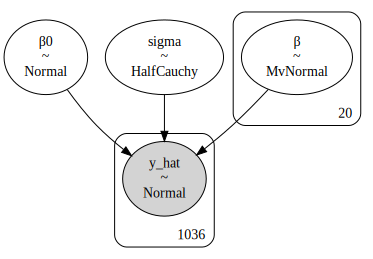

In [164]:
revenue_shape = movies_revenue.shape[1]
with pm.Model() as full_model:
    Y = np.log(y_pred)
    β0 = pm.Normal('β0', mu=0, sigma=10)
    β = pm.MvNormal('β', mu=np.zeros(revenue_shape),cov=np.eye(revenue_shape),shape=revenue_shape)
    μ = β0 + pm.math.dot(movies_revenue,β)
    sigma = pm.HalfCauchy('sigma',beta=5)
    #p = pm.Deterministic('p', pm.invlogit(μ))
    y_hat = pm.Normal('y_hat', mu=μ, sigma=sigma,observed=Y)
pm.model_to_graphviz(full_model)

In [165]:
advi_fit = pm.fit(50000, method = 'advi', model=full_model)

Finished [100%]: Average Loss = 1,455.9


In [106]:
movies_revenue.columns

Index(['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6',
       'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'tomatometer_rating',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'budget', 'runtime', 'content_rating_G', 'content_rating_NR',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_R'],
      dtype='object')

In [35]:
#use credible intervals, WAIC

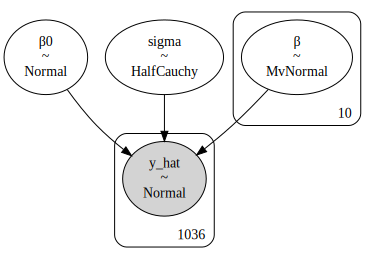

In [108]:
revenue_shape = movies_revenue.shape[1]
with pm.Model() as reduced_model:
    Y = np.log(y_pred)
    β0 = pm.Normal('β0', mu=0, sigma=10)
    β = pm.MvNormal('β', mu=np.zeros(revenue_shape-10),cov=np.eye(revenue_shape-10),shape=revenue_shape-10)
    μ = β0 + pm.math.dot(movies_revenue.iloc[:,10:21],β)
    sigma = pm.HalfCauchy('sigma',beta=5)
    #p = pm.Deterministic('p', pm.invlogit(μ))
    y_hat = pm.Normal('y_hat', mu=μ, sigma=sigma,observed=Y)
pm.model_to_graphviz(reduced_model)

In [109]:
advi_reduced = pm.fit(50000, method = 'advi', model=reduced_model)

Finished [100%]: Average Loss = 1,467


In [167]:
with pm.Model() as reduced_model:
    Y = np.log(y_pred)
    β0 = pm.Normal('β0', mu=0, sigma=10)
    β = pm.MvNormal('β', mu=np.zeros(revenue_shape-10),cov=np.eye(revenue_shape-10),shape=revenue_shape-10)
    μ = β0 + pm.math.dot(movies_revenue.iloc[:,10:21],β)
    sigma = pm.HalfCauchy('sigma',beta=5)
    #p = pm.Deterministic('p', pm.invlogit(μ))
    y_hat = pm.Normal('y_hat', mu=μ, sigma=sigma,observed=Y)
    binout2 = pm.sample(5000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β0, β, sigma]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 119 seconds.


In [161]:
with pm.Model() as full_model:
    Y = np.log(y_pred)
    β0 = pm.Normal('β0', mu=0, sigma=10)
    β = pm.MvNormal('β', mu=np.zeros(revenue_shape),cov=np.eye(revenue_shape),shape=revenue_shape)
    μ = β0 + pm.math.dot(movies_revenue,β)
    sigma = pm.HalfCauchy('sigma',beta=5)
    #p = pm.Deterministic('p', pm.invlogit(μ))
    y_hat = pm.Normal('y_hat', mu=μ, sigma=sigma,observed=Y)
    binout = pm.sample(5000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β0, β, sigma]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 458 seconds.


In [110]:
PPC_SAMPLES = 5000
advi_fit_sample = advi_fit.sample(PPC_SAMPLES)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

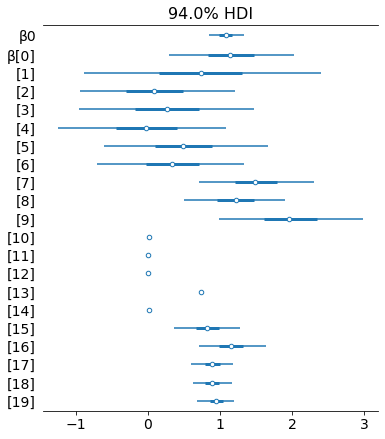

In [112]:
pm.plot_forest(advi_fit_sample, var_names=['β0','β'])

In [113]:
advi_fit_reduced = advi_reduced.sample(PPC_SAMPLES)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

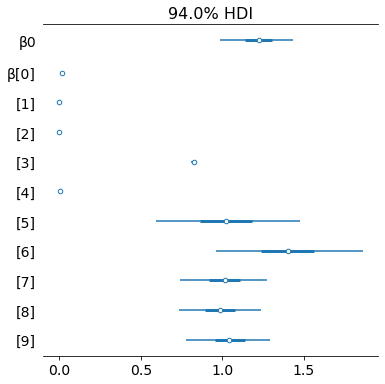

In [114]:
pm.plot_forest(advi_fit_reduced, var_names=['β0','β'])

In [47]:
import seaborn as sns

Text(0.5, 1.0, 'Full Model ELBO vs. time')

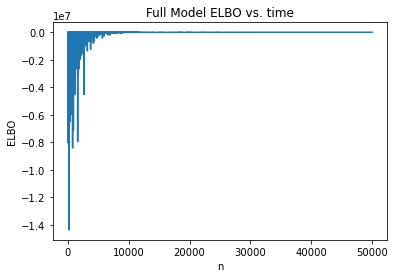

In [115]:
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit.hist,
     'n':np.arange(advi_fit.hist.shape[0])
    }
)
ax = sns.lineplot(y='ELBO',x='n',data=advi_elbo)
ax.set_title("Full Model ELBO vs. time")

Text(0.5, 1.0, 'Reduced Model ELBO vs. time')

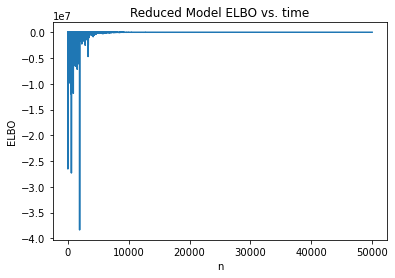

In [117]:
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_reduced.hist,
     'n':np.arange(advi_reduced.hist.shape[0])
    }
)
ax = sns.lineplot(y='ELBO',x='n',data=advi_elbo)
ax.set_title("Reduced Model ELBO vs. time")

In [118]:
b =  advi_fit_sample.posterior["β"][:,:,0]
OR = np.mean(b, axis =0)

lb, ub = np.percentile(OR, 2.5), np.percentile(OR, 97.5)

print("P({:.3f} < O.R. < {:.3f}) = 0.95".format(np.exp(lb), np.exp(ub)))

P(1.277 < O.R. < 7.791) = 0.95


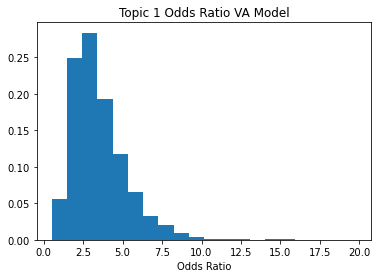

In [119]:
b =  advi_fit_sample.posterior["β"][:,:,0]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Topic 1 Odds Ratio VA Model")
plt.show()

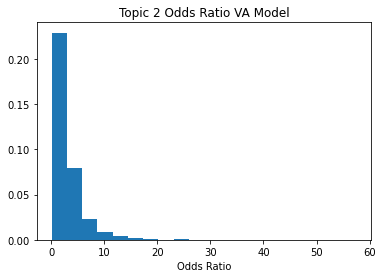

In [120]:
b =  advi_fit_sample.posterior["β"][:,:,1]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Topic 2 Odds Ratio VA Model")
plt.show()

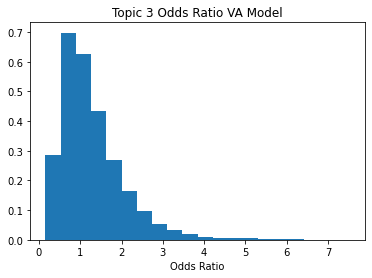

In [121]:
b =  advi_fit_sample.posterior["β"][:,:,2]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Topic 3 Odds Ratio VA Model")
plt.show()

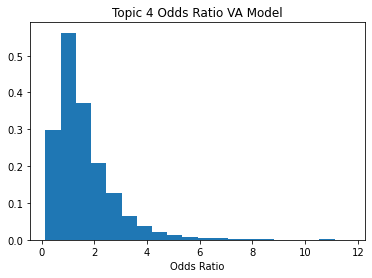

In [122]:
b =  advi_fit_sample.posterior["β"][:,:,3]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Topic 4 Odds Ratio VA Model")
plt.show()

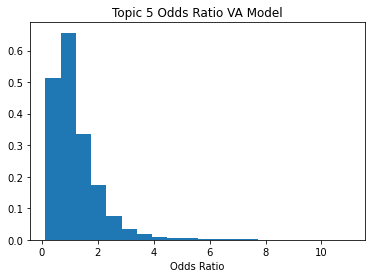

In [123]:
b =  advi_fit_sample.posterior["β"][:,:,4]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Topic 5 Odds Ratio VA Model")
plt.show()

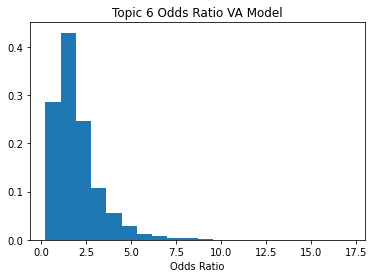

In [124]:
b =  advi_fit_sample.posterior["β"][:,:,5]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Topic 6 Odds Ratio VA Model")
plt.show()

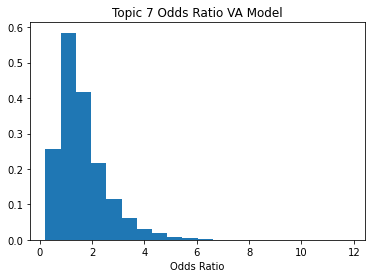

In [125]:
b =  advi_fit_sample.posterior["β"][:,:,6]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Topic 7 Odds Ratio VA Model")
plt.show()

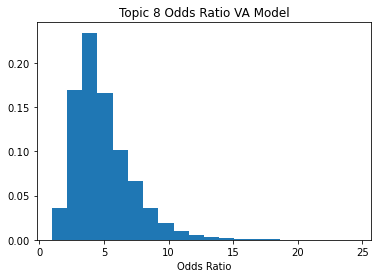

In [126]:
b =  advi_fit_sample.posterior["β"][:,:,7]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Topic 8 Odds Ratio VA Model")
plt.show()

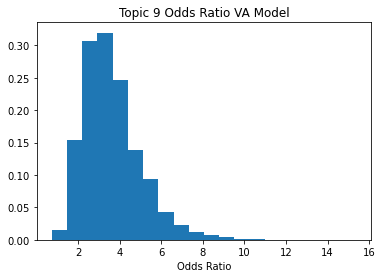

In [127]:
b =  advi_fit_sample.posterior["β"][:,:,8]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Topic 9 Odds Ratio VA Model")
plt.show()

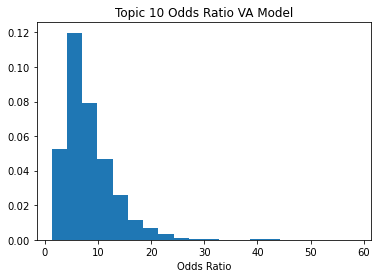

In [128]:
b =  advi_fit_sample.posterior["β"][:,:,9]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Topic 10 Odds Ratio VA Model")
plt.show()

In [129]:
movies_revenue.columns

Index(['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6',
       'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'tomatometer_rating',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'budget', 'runtime', 'content_rating_G', 'content_rating_NR',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_R'],
      dtype='object')

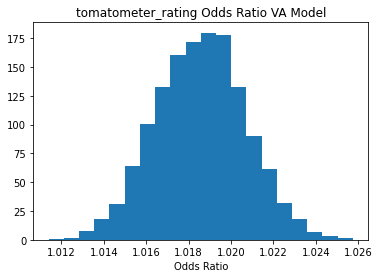

In [130]:
b =  advi_fit_sample.posterior["β"][:,:,10]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("tomatometer_rating Odds Ratio VA Model")
plt.show()

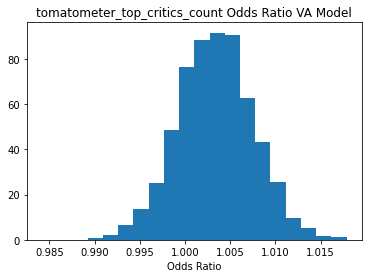

In [131]:
b =  advi_fit_sample.posterior["β"][:,:,11]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("tomatometer_top_critics_count Odds Ratio VA Model")
plt.show()

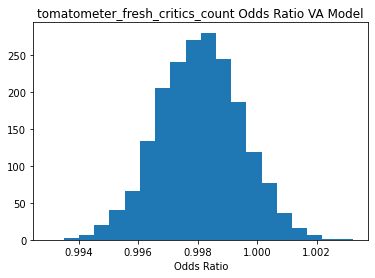

In [132]:
b =  advi_fit_sample.posterior["β"][:,:,12]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("tomatometer_fresh_critics_count Odds Ratio VA Model")
plt.show()

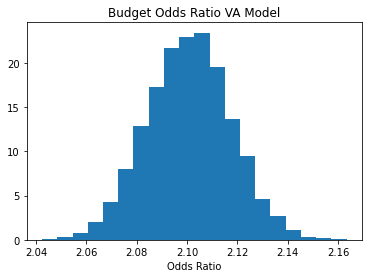

In [133]:
b =  advi_fit_sample.posterior["β"][:,:,13]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Budget Odds Ratio VA Model")
plt.show()

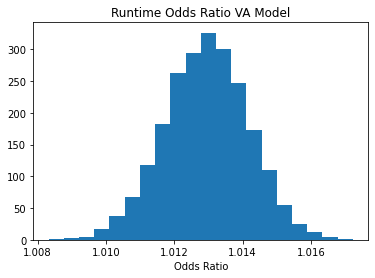

In [134]:
b =  advi_fit_sample.posterior["β"][:,:,14]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Runtime Odds Ratio VA Model")
plt.show()

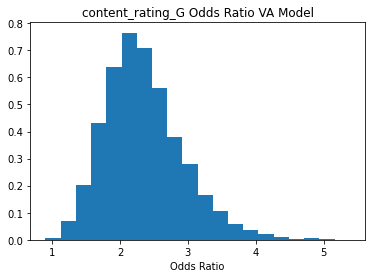

In [135]:
b =  advi_fit_sample.posterior["β"][:,:,15]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("content_rating_G Odds Ratio VA Model")
plt.show()

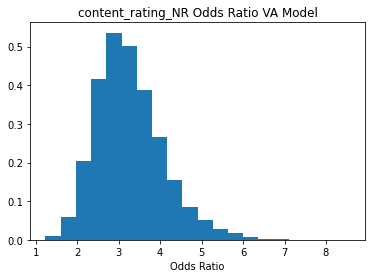

In [136]:
b =  advi_fit_sample.posterior["β"][:,:,16]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("content_rating_NR Odds Ratio VA Model")
plt.show()

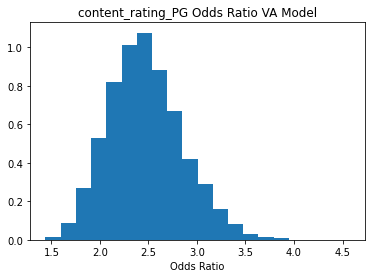

In [137]:
b =  advi_fit_sample.posterior["β"][:,:,17]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("content_rating_PG Odds Ratio VA Model")
plt.show()

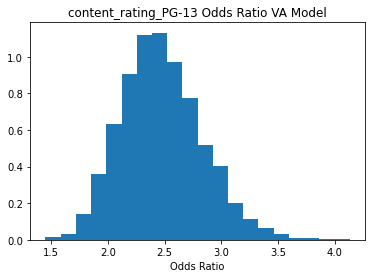

In [138]:
b =  advi_fit_sample.posterior["β"][:,:,18]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("content_rating_PG-13 Odds Ratio VA Model")
plt.show()

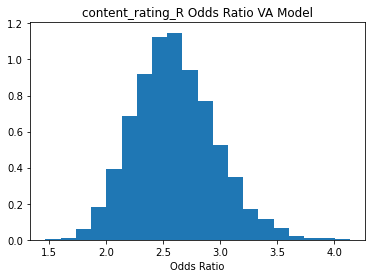

In [139]:
b =  advi_fit_sample.posterior["β"][:,:,19]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("content_rating_R Odds Ratio VA Model")
plt.show()

In [168]:
#WAIC
cmp_waic = az.compare({'full_model':binout, 'simple_model':binout2}, ic='waic')
cmp_waic

/Users/aubrey/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/aubrey/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
simple_model,0,-277.173244,11.282681,0.000000,0.703844,15.861352,0.000000,True,log
full_model,1,-279.749087,20.093601,2.575843,0.296156,15.965787,3.547171,True,log


In [170]:
az.waic(binout,full_model)

/Users/aubrey/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 10000 posterior samples and 1036 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -279.75    15.97
p_waic       20.09        -

There has been a warning during the calculation. Please check the results.

In [169]:
#LOO
cmp_loo = az.compare({'full_model':binout, 'simple_model':binout2}, ic='loo',scale='deviance')
cmp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
simple_model,0,554.487196,11.353035,0.000000,0.706628,31.734781,0.000000,False,deviance
full_model,1,559.700892,20.194960,5.213696,0.293372,31.951500,7.089513,False,deviance


In [171]:
az.waic(binout2,full_model)

/Users/aubrey/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 10000 posterior samples and 1036 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -277.17    15.86
p_waic       11.28        -

There has been a warning during the calculation. Please check the results.